In [1]:
import sys
sys.path.append("../")

In [2]:
import os
import logging
from typing import List, Tuple

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

from src.models.vit import (
    PatcheLayer,
    PatchEncodeLayer,
    FeedForwardLayer,
    EncoderLayer,
    Encoder,
    VisionTransformer,
)
from src.utils.logger import get_logger
from src.utils.session import reset_session
from src.utils.plot import plot_history

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

2024-12-28 12:30:49.448088: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
_ = get_logger()

## Load Dataset

In [4]:
(X_train_raw, y_train_raw), (X_test_raw, y_test_raw) = tf.keras.datasets.mnist.load_data()
X_train_raw = np.expand_dims(X_train_raw, axis=3)
X_test_raw = np.expand_dims(X_test_raw, axis=3)

print(f"X_train: {X_train_raw.shape}")
print(f"y_train: {y_train_raw.shape}")

print(f"X_test: {X_test_raw.shape}")
print(f"y_test: {y_test_raw.shape}")

X_train: (60000, 28, 28, 1)
y_train: (60000,)
X_test: (10000, 28, 28, 1)
y_test: (10000,)


## Example: Patch Sequences

In [5]:
bs = 16
ps = 4
inputs = X_train_raw[:bs]
targets = y_train_raw[:bs]

layer_p = PatcheLayer(ps)
patches = layer_p(inputs)

2024-12-28 12:30:51.825962: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-12-28 12:30:51.834864: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-12-28 12:30:51.835391: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-12-28 12:30:51.836954: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

In [6]:
def draw_patches(
    raw: np.ndarray,
    patches: np.ndarray,
    patch_size: int = 4,
) -> plt.Figure:
    grid_size = int(raw.shape[0] / patch_size)
    
    fig = plt.figure()
    subfigs = fig.subfigures(1, 2, width_ratios=(1, 1))
    ax = subfigs[0].subplots(1, 1)
    ax.imshow(raw)
    ax.axis("off")
    
    axs = subfigs[1].subplots(grid_size, grid_size)
    for i, patch in enumerate(patches):
        row, col = divmod(i, grid_size)
        ax = axs[row, col]
        ax.imshow(patch.reshape(patch_size, patch_size, -1))
        ax.axis("off")
    
    subfigs[0].suptitle("Original", y=0.8)
    
    subfigs[1].suptitle("Patches", y=0.8)
    subfigs[1].subplots_adjust(top=0.76, bottom=0.23, wspace=0.1, hspace=0.1)
    return fig

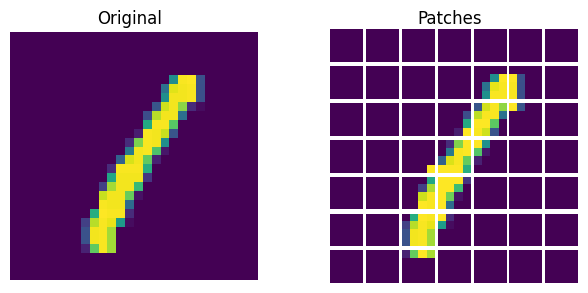

In [7]:
i = 3
ori = inputs[i]
pcs = patches[i].numpy()
_ = draw_patches(ori, pcs, patch_size=ps)

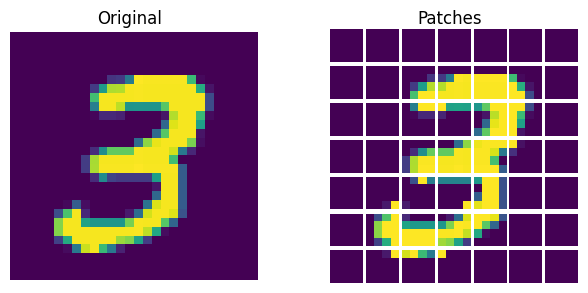

In [8]:
i = 7
ori = inputs[i]
pcs = patches[i].numpy()
_ = draw_patches(ori, pcs, patch_size=ps)

## Preprocess

In [9]:
X_train = X_train_raw / 255.
X_test = X_test_raw / 255.

y_train = y_train_raw.astype("float")
y_test = y_test_raw.astype("float")

In [10]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train,
    y_train,
    test_size=0.1,
    random_state=1234
)

print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")

print(f"X_valid: {X_valid.shape}")
print(f"y_valid: {y_valid.shape}")

print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")

X_train: (54000, 28, 28, 1)
y_train: (54000,)
X_valid: (6000, 28, 28, 1)
y_valid: (6000,)
X_test: (10000, 28, 28, 1)
y_test: (10000,)


## Train model

In [11]:
# model config
input_shape = (28, 28, 1)
num_classes = 10
resize = 32
patch_size = 4
projection_dim = 64
num_heads = 4
num_encoder_blocks = 2
mlp_hidden_units = [512, 128]
dropout_rate = 0.1
learning_rate = 1e-3


# train config
batch_size = 256
epochs = 20

base_model_dir = "../model/"
os.makedirs(base_model_dir, exist_ok=True)
ckpt_path = os.path.join(base_model_dir, "vit_image_clf", "ckpt")

es_cb = tf.keras.callbacks.EarlyStopping(patience=10, mode="min", verbose=1)
ckpt_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath=ckpt_path,
    mode="min",
    save_best_only=True,
    save_weights_only=True,
    verbose=1,    
)
callbacks = [es_cb, ckpt_cb]

In [12]:
reset_session()

In [13]:
vit = VisionTransformer(
    input_shape=input_shape,
    num_classes=num_classes,
    resize=resize,
    patch_size=patch_size,
    projection_dim=projection_dim,
    num_heads=num_heads,
    num_encoder_blocks=num_encoder_blocks,
    mlp_hidden_units=mlp_hidden_units,
    dropout_rate=dropout_rate,
    learning_rate=learning_rate,
)

In [14]:
vit.build()

In [15]:
model = vit.model

In [16]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 encoder (Encoder)           (None, 64, 64)            171584    
                                                                 
 layer_normalization_4 (Laye  (None, 64, 64)           128       
 rNormalization)                                                 
                                                                 
 flatten (Flatten)           (None, 4096)              0         
                                                                 
 dropout_4 (Dropout)         (None, 4096)              0         
                                                             

In [17]:
history = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_valid, y_valid),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/20


2024-12-28 12:30:58.362575: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2024-12-28 12:30:58.391642: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f779cb3d2a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-12-28 12:30:58.391668: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 2070, Compute Capability 7.5
2024-12-28 12:30:58.394857: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-28 12:30:58.486950: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


209/211 [============================>.] - ETA: 0s - loss: 0.8128 - accuracy: 0.7454   
Epoch 1: val_loss improved from inf to 0.23897, saving model to ../model/vit_image_clf/ckpt
211/211 [==============================] - 13s 33ms/step - loss: 0.8087 - accuracy: 0.7469 - val_loss: 0.2390 - val_accuracy: 0.9292
Epoch 2/20
211/211 [==============================] - ETA: 0s - loss: 0.2950 - accuracy: 0.9164
Epoch 2: val_loss improved from 0.23897 to 0.12027, saving model to ../model/vit_image_clf/ckpt
211/211 [==============================] - 7s 33ms/step - loss: 0.2950 - accuracy: 0.9164 - val_loss: 0.1203 - val_accuracy: 0.9617
Epoch 3/20
211/211 [==============================] - ETA: 0s - loss: 0.1929 - accuracy: 0.9439
Epoch 3: val_loss improved from 0.12027 to 0.08402, saving model to ../model/vit_image_clf/ckpt
211/211 [==============================] - 7s 31ms/step - loss: 0.1929 - accuracy: 0.9439 - val_loss: 0.0840 - val_accuracy: 0.9742
Epoch 4/20
209/211 [===================

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Epoch', ylabel='Cross-Entropy'>)

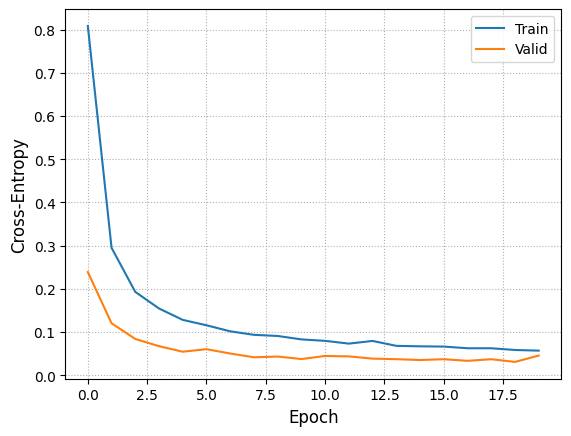

In [18]:
plot_history(history, ylabel="Cross-Entropy")

In [19]:
model.load_weights(ckpt_path)

In [20]:
model.evaluate(X_train, y_train, batch_size=batch_size)

211/211 [==============================] - 3s 15ms/step - loss: 0.0128 - accuracy: 0.9958


[0.012807033956050873, 0.9958333373069763]

In [21]:
model.evaluate(X_test, y_test, batch_size=batch_size)

40/40 [==============================] - 1s 15ms/step - loss: 0.0374 - accuracy: 0.9880


[0.03742685168981552, 0.9879999756813049]

In [22]:
# inps = X_train[:bs]
# tars = y_train[:bs]
# outs = vit.model(inps)
# tf.keras.losses.SparseCategoricalCrossentropy()(tars, outs)